<a href="https://colab.research.google.com/github/tanaxer01/mov-in-covid/blob/main/index_calcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ ! -d mov-in-covid ]; then \
  git clone https://github.com/tanaxer01/mov-in-covid; \
  mv mov-in-covid/*.py .; fi

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import utils

Cloning into 'mov-in-covid'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 37 (delta 16), reused 14 (delta 2), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [ ]:
datasets = {
  # DP1
  "dp1_contagios": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19_std.csv",
  # DP 8
  # DP51
  "dp51_difs": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto51/ISCI_std.csv",
  # DP82
  "dp82_weeks": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weeks.csv",
  "dp82_weekends": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weekends.csv",
  # DP...
}

for name, url in datasets.items():
  utils.get_file(name, url)

[+] created ./datos/
[+] downloaded ./datos/dp1_contagios
[+] downloaded ./datos/dp51_difs
[+] downloaded ./datos/dp82_weeks
[+] downloaded ./datos/dp82_weekends


# DATASET PREP

## DP1
link: [product1](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto1)

In [80]:
DataProduct1 = pd.read_csv("./datos/dp1_contagios.csv", parse_dates=["Fecha"])

# Just RM
DataProduct1 = DataProduct1[ DataProduct1["Codigo region"] == 13 ].drop(columns=["Region", "Codigo region"])
DataProduct1 = DataProduct1.set_index("Fecha")

# Week num
DataProduct1["Semana"] = (DataProduct1.index.to_series() - datetime.strptime("2020-01-01", "%Y-%m-%d")).dt.days // 7

# Drop `Desconocido Metropolitana`
DataProduct1 = DataProduct1[ DataProduct1.Comuna != "Desconocido Metropolitana" ]

casos = pd.DataFrame({ i:DataProduct1[ DataProduct1.Comuna == i ].groupby("Semana")["Casos confirmados"].mean() for i in set(DataProduct1.Comuna) }) 
casos_nuevos = casos.subtract( casos.shift(periods=1, fill_value=0) )

## cov_all: Cantidad de contagios acumulativa x comuna(columnas) y fecha(index)
cov_all = DataProduct1.pivot_table(values="Casos confirmados", index="Fecha", columns="Comuna")
## cov_new: Cantidad de contagios nuevos x comuna(columnas) y fecha(index)
cov_new = cov_all.subtract( cov_all.shift(periods=1, fill_value=0) )

cov_new.shape, cov_all.shape

((275, 52), (275, 52))

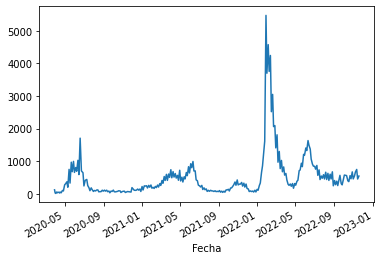

In [81]:
cov_new["Santiago"].plot()

### Parsing DP1 data 

In [82]:
week2date = lambda x: datetime.strptime("2020-01-01", "%Y-%m-%d") + timedelta(days=x*7)

mondays = cov_new.Santiago[ cov_new.Santiago.index.to_series().dt.weekday == 0 ]

fridays = cov_new.Santiago[ cov_new.Santiago.index.to_series().dt.weekday == 4 ].reset_index()
fridays["Fecha"] = fridays["Fecha"] - timedelta(days=0.5)
fridays = fridays.set_index("Fecha")["Santiago"]

new_index = pd.date_range(start=cov_new.index.min(), end=cov_new.index.max(), freq="3.5D")

## OUT DATA del DP1
# cov_mod: Misma serie de contagios, pero fechas de dia viernes fueron corridas 12 horas hacia atras.
cov_mod = pd.Series(pd.concat([mondays, fridays]), index=new_index).interpolate().rename("casos")

### Seasonalinty in the dataset
A primera vista, se ve que dentro de los 3 años hay un aumento de contagios entre mayo y julio. Pero hay algunos aumentos anomalos, a principios de 2022 hay un amuendo drastico de contagios el que creemos se debe a la variante OMICRON.

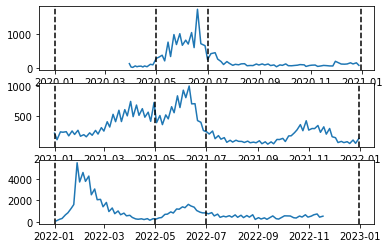

In [83]:
plt.subplot(3,1,1)
plt.plot( cov_new["Santiago"].loc["2020-01-01":"2020-12-31"] )

for i in ["2020-01-01","2020-12-31","2020-05-01","2020-07-01"]:
  plt.axvline(x=datetime.strptime(i,"%Y-%m-%d"), color='black', linestyle='--')

plt.subplot(3,1,2)
plt.plot( cov_new["Santiago"].loc["2021-01-01":"2021-12-31"] )

for i in ["2021-01-01","2021-12-31", "2021-05-01", "2021-07-01"]:
  plt.axvline(x=datetime.strptime(i,"%Y-%m-%d"), color='black', linestyle='--')

plt.subplot(3,1,3)
plt.plot( cov_new["Santiago"].loc["2022-01-01":"2022-12-31"] )

for i in ["2022-01-01","2022-12-31", "2022-05-01","2022-07-01"]:
  plt.axvline(x=datetime.strptime(i,"%Y-%m-%d"), color='black', linestyle='--')
  
plt.show()

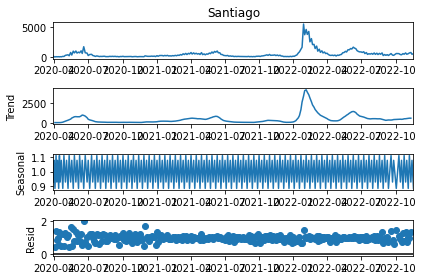

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(cov_new["Santiago"], period=4, model="multiplicative").plot()

## DP 8
link: [product8](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto8)

## DP51
link: [product51](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto51)


In [85]:
df_difs = pd.read_csv("./datos/dp51_difs.csv")

# Fecha to Datetime && sort by Fecha
df_difs['Fecha'] = pd.to_datetime(df_difs['Fecha'])
df_difs = df_difs.sort_values(by=['Fecha'])

# Just RM
df_difs = df_difs[ df_difs['Codigo region'] == 13 ].drop(columns=['Region', 'Codigo region'])


# Calc prom of Dif salida y Dif entrada.
def parse_diff(x):
  mean = sum([ int(i)  for i in x[1:-2].replace('%','').split(",") ])/2
  
  return (100 + mean)/100

df_difs['Salida'] = df_difs['Dif salida'].map(parse_diff)
df_difs['Entrada'] = df_difs['Dif entrada'].map(parse_diff)

df_salidas  = pd.DataFrame({ i:df_difs[ df_difs["Comuna"] == i ].groupby("Week")["Salida"].mean() for i in set(df_difs["Comuna"]) })
df_entradas = pd.DataFrame({ i:df_difs[ df_difs["Comuna"] == i ].groupby("Week")["Entrada"].mean() for i in set(df_difs["Comuna"]) })

In [86]:
df_salidas.head()


,María Pinto,Recoleta,Puente Alto,Huechuraba,Talagante,Calera de Tango,Isla de Maipo,Curacaví,Lampa,El Bosque,...,Alhué,La Florida,Peñalolén,Lo Espejo,San Ramón,Pudahuel,Macul,Padre Hurtado,Paine,Renca
Week,,,,,,,,,,,,,,,,,,,,,
9,1.670000,1.265000,1.154718,1.149286,1.157,1.265000,1.1975,1.29875,1.076,1.265000,...,0.995,1.184252,1.096250,1.1570,1.031818,1.204032,1.176212,1.068636,1.128125,1.197500
10,1.670000,1.265000,1.154718,1.149286,1.157,1.265000,1.1975,1.29875,1.076,1.265000,...,0.995,1.184252,1.096250,1.1570,1.031818,1.204032,1.166818,1.068636,1.146875,1.197500
11,1.620000,1.218333,1.114577,1.006429,1.137,1.198333,1.1225,1.29875,0.931,1.257308,...,0.695,1.133785,0.994464,1.1694,1.018182,1.175000,1.057727,1.041364,1.040625,1.197500
12,1.586667,1.140556,0.976549,0.863571,0.957,1.020556,0.9850,1.18625,0.841,1.172692,...,0.495,0.978645,0.874821,1.0850,0.936364,1.025000,0.948636,0.805000,0.865625,1.108864
13,1.586667,1.098333,0.973028,0.873095,0.957,1.020556,0.9475,1.22375,0.806,1.149615,...,0.195,0.985187,0.828393,1.0610,0.909091,1.039516,0.912273,0.832273,0.871875,1.054318


## DP82
link: [product82](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto82)

In [87]:
df_weeks = pd.read_csv('./datos/dp82_weeks.csv')
#df_weekends = pd.read_csv('./datos/dp82_weekends.csv')

# Fecha to Datetime && sort by Fecha
df_weeks['fecha_inicio'] = pd.to_datetime(df_weeks['fecha_inicio'])
df_weeks = df_weeks.sort_values(by=['fecha_inicio'])

# Just RM
df_weeks = df_weeks[ df_weeks['region'] == 13 ].drop(columns=['region'])

# Just dates on DP51
# df_weeks = df_weeks[ df_weeks["fecha_inicio"].isin(df_difs["Fecha"]) ]

# [!] Fill pasos 
df_weeks["paso"] = df_weeks["paso"].fillna(method="ffill")

# paso_a_paso: 
paso_a_paso = df_weeks.pivot_table(values='paso', index='semana', columns='nom_comuna')

# paso_out: Dataframe del paso a paso con las muestras cada 3.5 días tal como el dataset de contagios
paso_out = paso_a_paso.reset_index()
paso_out["semana"] = paso_out["semana"].apply(week2date) - timedelta(days=2)
paso_out = paso_out.set_index("semana").asfreq("84H").interpolate().rename(columns={ i:"pasos-"+i for i in paso_out.columns})

# var_salidas:
var_salidas = df_weeks.pivot_table(values="var_salidas", index="semana", columns="nom_comuna")

# var_out: Dataframe del indice de movilidad con las muestras cada 3.5 días tal como el dataset de contagios
var_out = var_salidas.reset_index()
var_out["semana"] = var_out["semana"].apply(week2date) - timedelta(days=2)
var_out = var_out.set_index("semana").asfreq("84H").interpolate().rename(columns={ i:"var-"+i for i in var_out.columns})

paso_out.shape, var_out.shape

((247, 51), (247, 51))

## Date checking within the datasets

In [88]:
# cov_mod = cov_mod / cov_mod.max()
# var_out = var_out / var_out.max()
# paso_out = paso_out / paso_out.max()


all = pd.concat([ cov_mod, var_out, paso_out ], axis=1).dropna()

## `Dif salida` VS `var_salidas`
En general siguen las mismas tendencias, pero tienen una diferencia de 0.2 que no estoy seguro pq ocurre.
Lo unico raro es la diferencia al final, (el peak hacia abajo es por un error de mediciones en uno de los datasets.) pero al final, el dataset `var` tiene un amuento raro que no se ve en la otra curva.

In [89]:
#dif  = df_salidas["Santiago"]
#var  = df_weeks[ df_weeks["nom_comuna"] == "SANTIAGO" ].set_index("fecha_inicio")
#
#var_salidas = var["var_salidas"]
#paso = var["paso"]
#
#plt.figure()
#
#plt.plot(paso / 8 + 0.5)
#plt.plot(var_salidas)
#plt.plot(dif - 0.2)
#
#plt.legend(["var", "dif"])
#plt.show()
#
#f"shift promedio entre var y dif: {(dif - var_salidas).mean()}"

# Medición de eficiencia

## Base model

In [ ]:
from sklearn.model_selection import train_test_split

semanas = [ i for i in var_salidas.index if i in casos.index]

paso_mod = paso_out.rename(columns={ i:"Paso-"+i for i in paso_out.columns})
X = var_out.join(paso_mod)

#X = var_salidas.loc[semanas].rename(columns={ i:"IM-"+i for i in var_salidas.columns }).join(df_pasos.rename(columns={ i:"paso-"+i for i in df_pasos.columns }))


y = cov_mod


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X.shape, y.shape

((247, 102), (276,))

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

reg = linear_model.LinearRegression()
reg.fit(X.head(70),y.head(70))

y_pred = reg.predict(X.tail(47))

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y.tail(47), y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y.tail(47), y_pred))

scores = cross_val_score(reg, X, y, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f AKA it sucks" % (scores.mean(), scores.std()))

plt.figure()
plt.plot(y.tail(47))
plt.plot(y.tail(47).index, y_pred)

plt.show()

## First Aproach

In [ ]:
week2day = lambda x: datetime.strptime("2020-01-01", "%Y-%m-%d") + timedelta(days=x*7)

endo_train, endo_test = all["casos"].iloc[:round(all.shape[0]*0.7)], all["casos"][round(all.shape[0]*0.7):]
exo_train,   exo_test = all.drop(columns=["casos"]).iloc[:round(all.shape[0]*0.7)], all["casos"][round(all.shape[0]*0.7):]

# fechas_train = [ i for i in exo_train.index if i in endo_train.index ]
# fechas_test = [ i for i in exo_test.index if i in endo_test.index ]

# endo_train = endo_train.loc[fechas_train]
# exo_train  =  exo_train.loc[fechas_train]

# endo_test = endo_test.loc[fechas_test]
# exo_test  =  exo_test.loc[fechas_test]

endo_train.index.freq = "84H"
exo_train.index.freq = "84H"

endo_test.index.freq = "84H"
exo_test.index.freq = "84H"

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax(ts, exo, all_params):
  results = []
  for param in all_params:
    try:
      mod = SARIMAX(ts, exog=exo, order=param[0], seasonal_order=param[1], \
                    enforce_stationarity = False, enforce_invertibility = False)
      res = mod.fit(maxiter=200, method='powell')

      results.append((res, res.aic,param))
      print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))

    except Exception as e:
      print(e)
      continue

  return results

In [ ]:
mod = SARIMAX(endo_train,exo=exo_train, order=(0,1,0), seasonal_order=(0, 1, 0, 7))
res = mod.fit(method="powell")
print("SARIMAX{}x{} - AIC:{}".format((0,1,0), (0,1,0,7),round(res.aic,2)))

Optimization terminated successfully.
         Current function value: -1.439453
         Iterations: 2
         Function evaluations: 57
SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:-478.78


In [ ]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

p,d,q = range(0,3),[1],range(0,3)

a = ARIMA(endo_train, exog=exo_train, seasonal_order=(0,1,0,7))
a_fit = a.fit()

a_fit.forecast()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ValueError: ignored

In [ ]:
import itertools

# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(endo_train,exo_train,all_param)

Optimization terminated successfully.
         Current function value: -1.453306
         Iterations: 2
         Function evaluations: 1210
Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:-381.4
Optimization terminated successfully.
         Current function value: -1.871550
         Iterations: 32
         Function evaluations: 17003
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:-519.1
Optimization terminated successfully.
         Current function value: -2.056594
         Iterations: 59
         Function evaluations: 33461
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 7) - AIC:-578.9


KeyboardInterrupt: ignored

Ljung-box p-values:
[1.00813003e-019 1.49749826e-036 9.90349969e-048 9.03587293e-058
 4.86251180e-069 2.18112362e-079 3.42777029e-097 3.74973516e-109
 1.33323412e-119 2.56988621e-127 1.00177689e-132 1.24329777e-136
 3.00331224e-140 5.63491287e-144]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             casos   No. Observations:                  167
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood                 240.389
Date:                           Wed, 23 Nov 2022   AIC                           -478.777
Time:                                   14:16:59   BIC                           -475.708
Sample:                               03-30-2020   HQIC                          -477.531
                                    - 11-01-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0028      0.000     17.534      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                  82.59   Jarque-Bera (JB):               219.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

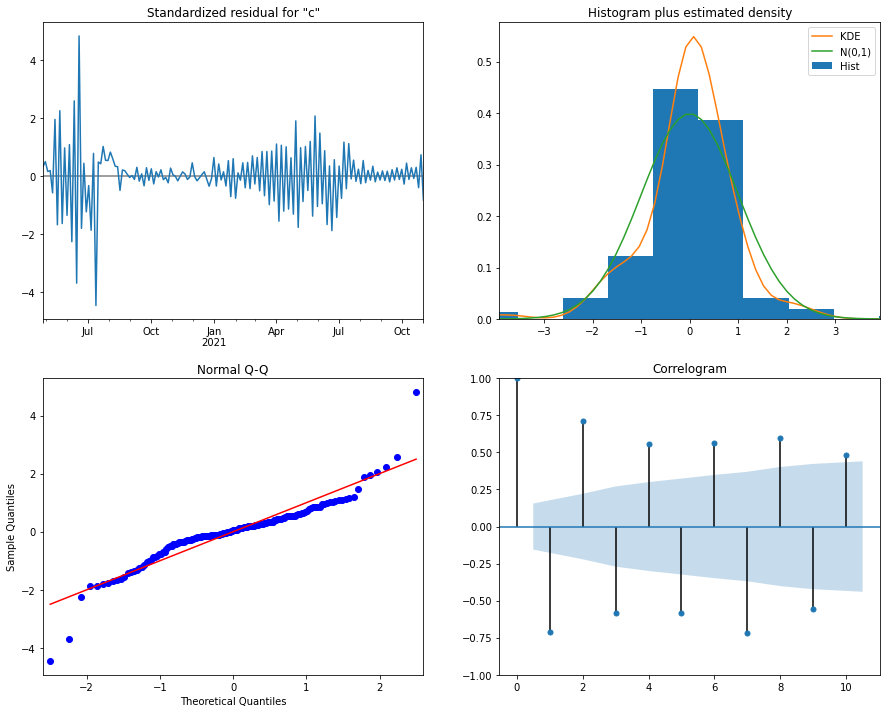

In [ ]:
res.plot_diagnostics(figsize=(15, 12))
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


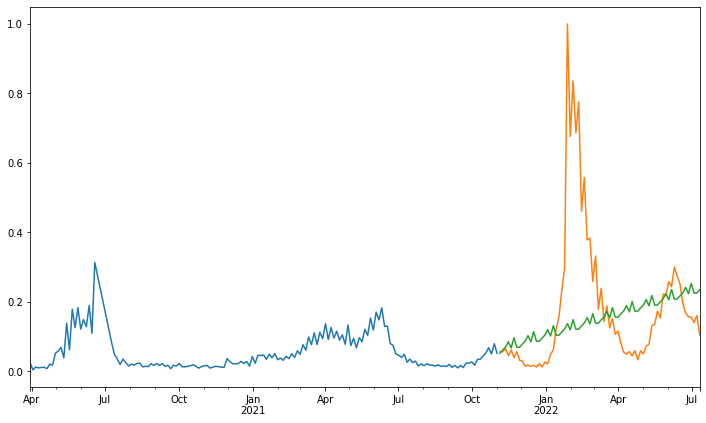

0.05516989404457435

In [ ]:
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE
from math import sqrt

train_start = endo_train.head(1).index.to_series().iloc[0]
train_end = endo_train.tail(1).index.to_series().iloc[0]

test_start = endo_test.head(1).index.to_series().iloc[0]
test_end = endo_test.tail(1).index.to_series().iloc[0]

testend = test_end + timedelta(days=3.5)
demo_start = endo_test.index.to_series().iloc[50]

#pred_test = res.get_prediction(start=test_start,end=testend ,exog=exo_test)
#err = 'Mean absolute percentage error: %.2f'% MAPE(endo_test, pred_test.predicted_mean) + \
# '\nRoot mean squared error: %.2f'% sqrt(MSE(endo_test, pred_test.predicted_mean))

pred = res.get_prediction(start=test_start,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))

endo_train.plot(ax=ax)
endo_test.loc[test_start:test_end].plot(ax=ax)

pred.predicted_mean.plot(ax=ax)
ci = pred_ci

#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
#plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
plt.show()

endo_test[ test_start + timedelta(days=3.5) ]

## Second 

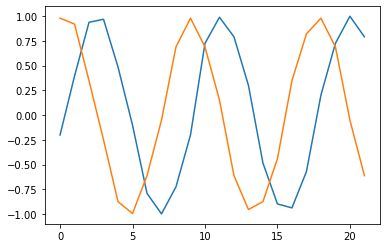

In [90]:
date = cov_mod.index.to_series()
days = date.dt.day

all['cov_sin'] = np.sin( (days * 2 * np.pi) / days.max())
all['cov_cos'] = np.cos( (days * 2 * np.pi) / days.max())


plt.plot(np.array(all['cov_sin'])[:22])
plt.plot(np.array(all['cov_cos'])[:22])

In [91]:
all.describe()

,casos,var-ALHUÉ,var-BUIN,var-CALERA DE TANGO,var-CERRILLOS,var-CERRO NAVIA,var-COLINA,var-CONCHALÍ,var-CURACAVÍ,var-EL BOSQUE,...,pasos-SAN JOSÉ DE MAIPO,pasos-SAN MIGUEL,pasos-SAN RAMÓN,pasos-SANTIAGO,pasos-TALAGANTE,pasos-TILTIL,pasos-VITACURA,pasos-ÑUÑOA,cov_sin,cov_cos
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,...,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,2.390000e+02,239.000000
mean,512.880753,0.742394,0.902979,0.885505,0.859130,0.867376,0.809631,0.853422,0.918507,0.904388,...,2.548117,2.405858,2.439331,2.600418,2.560669,2.673640,2.705021,2.738494,1.078286e-02,-0.011785
std,735.910974,0.381725,0.150979,0.160989,0.117828,0.114131,0.156344,0.120413,0.129322,0.125757,...,1.352824,1.276002,1.263989,1.178127,1.330982,1.314782,1.194928,1.129774,7.143935e-01,0.702558
min,17.000000,0.234691,0.534907,0.498236,0.487216,0.461811,0.456192,0.503848,0.646424,0.500244,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-9.987165e-01,-0.994869
25%,107.500000,0.470512,0.810116,0.786954,0.797672,0.792131,0.721592,0.781212,0.838801,0.842242,...,1.000000,1.000000,1.000000,1.000000,1.500000,2.000000,2.000000,2.000000,-7.247928e-01,-0.685432
50%,263.000000,0.655662,0.918148,0.908353,0.853059,0.849781,0.823007,0.833559,0.923274,0.907781,...,3.000000,2.000000,2.500000,3.000000,3.000000,3.000000,3.000000,3.000000,-2.449294e-16,-0.050649
75%,660.000000,0.853619,0.968901,0.941737,0.911034,0.908532,0.886418,0.900232,0.960755,0.950790,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,7.247928e-01,0.688967
max,5474.000000,1.588193,1.172378,1.172989,1.082171,1.096292,1.096655,1.091611,1.152432,1.136374,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,9.987165e-01,1.000000


In [92]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_casos = MinMaxScaler(feature_range=(0, 1)).fit(all[["casos"]])

all_normalized = pd.DataFrame(scaler.fit_transform(all), columns = all.columns.values, index = all.index)
all_normalized

,casos,var-ALHUÉ,var-BUIN,var-CALERA DE TANGO,var-CERRILLOS,var-CERRO NAVIA,var-COLINA,var-CONCHALÍ,var-CURACAVÍ,var-EL BOSQUE,...,pasos-SAN JOSÉ DE MAIPO,pasos-SAN MIGUEL,pasos-SAN RAMÓN,pasos-SANTIAGO,pasos-TALAGANTE,pasos-TILTIL,pasos-VITACURA,pasos-ÑUÑOA,cov_sin,cov_cos
2020-03-30 00:00:00,0.020158,0.106882,0.214546,0.159417,0.388687,0.408208,0.119932,0.329012,0.144427,0.364724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.25,0.399221,0.989739
2020-04-02 12:00:00,0.000000,0.060422,0.208714,0.168379,0.377382,0.429445,0.136709,0.346219,0.145572,0.403810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.25,0.697431,0.959375
2020-04-06 00:00:00,0.008063,0.013961,0.202881,0.177341,0.366076,0.450681,0.153486,0.363425,0.146717,0.442895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.25,0.969479,0.672813
2020-04-09 12:00:00,0.006047,0.011329,0.208049,0.202241,0.397024,0.453799,0.170045,0.372964,0.139266,0.414455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.25,0.984661,0.373065
2020-04-13 00:00:00,0.006780,0.008696,0.213216,0.227141,0.427972,0.456917,0.186605,0.382503,0.131815,0.386015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.25,0.742963,0.060416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27 00:00:00,0.153198,0.807642,0.973433,0.951874,0.959566,0.950897,0.897001,0.940946,0.932659,0.955052,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.00,0.137138,0.844083
2022-06-30 12:00:00,0.152465,0.854259,0.922493,0.914214,0.929643,0.930178,0.869008,0.927455,0.909634,0.919999,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.00,0.399221,0.989739
2022-07-04 00:00:00,0.136522,0.900876,0.871553,0.876553,0.899720,0.909458,0.841014,0.913964,0.886608,0.884945,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.00,0.862862,0.844083
2022-07-07 12:00:00,0.157229,0.889514,0.850023,0.857211,0.888655,0.892388,0.829766,0.919591,0.934874,0.876774,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.00,0.994869,0.574623


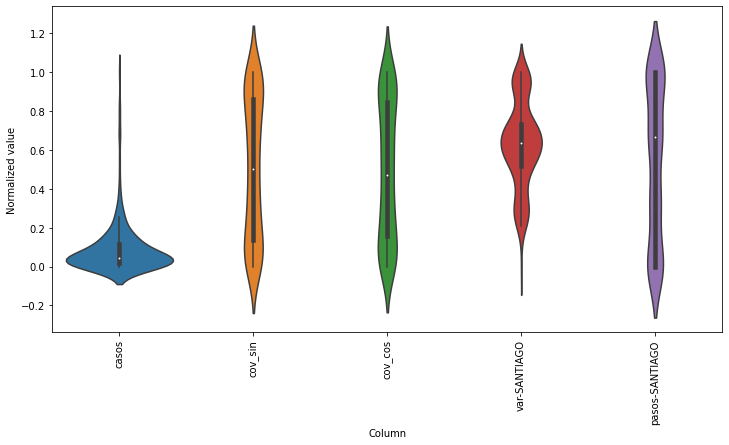

In [93]:
import seaborn as sns

melt_plot = all_normalized[["casos", "cov_sin", "cov_cos", "var-SANTIAGO", "pasos-SANTIAGO"]].melt(var_name='Column', value_name='Normalized value')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized value', data=melt_plot)
_ = ax.set_xticklabels(all_normalized[["casos", "cov_sin", "cov_cos", "var-SANTIAGO", "pasos-SANTIAGO"]].keys(), rotation=90)

In [94]:
train_end = all.index.to_series().iloc[ round(all.index.to_series().shape[0] * 0.7) ]
test_end = all.index.max()
demo_end = all.index.to_series().iloc[ round(all.index.to_series().shape[0] * 0.9) ]

test_df = all_normalized[train_end:]
train_val = all_normalized[:train_end]

n = len(train_val)

train_df = train_val[:int(n*0.8)]
val_df = train_val[int(n*0.8):]

column_indices = {name: i for i, name in enumerate(all.columns)}
num_features = all.shape[1]
train_df

,casos,var-ALHUÉ,var-BUIN,var-CALERA DE TANGO,var-CERRILLOS,var-CERRO NAVIA,var-COLINA,var-CONCHALÍ,var-CURACAVÍ,var-EL BOSQUE,...,pasos-SAN JOSÉ DE MAIPO,pasos-SAN MIGUEL,pasos-SAN RAMÓN,pasos-SANTIAGO,pasos-TALAGANTE,pasos-TILTIL,pasos-VITACURA,pasos-ÑUÑOA,cov_sin,cov_cos
2020-03-30 00:00:00,0.020158,0.106882,0.214546,0.159417,0.388687,0.408208,0.119932,0.329012,0.144427,0.364724,...,0.000,0.000,0.000,0.000000,0.000,0.000,0.250,0.250,0.399221,0.989739
2020-04-02 12:00:00,0.000000,0.060422,0.208714,0.168379,0.377382,0.429445,0.136709,0.346219,0.145572,0.403810,...,0.000,0.000,0.000,0.000000,0.000,0.000,0.250,0.250,0.697431,0.959375
2020-04-06 00:00:00,0.008063,0.013961,0.202881,0.177341,0.366076,0.450681,0.153486,0.363425,0.146717,0.442895,...,0.000,0.000,0.000,0.000000,0.000,0.000,0.250,0.250,0.969479,0.672813
2020-04-09 12:00:00,0.006047,0.011329,0.208049,0.202241,0.397024,0.453799,0.170045,0.372964,0.139266,0.414455,...,0.000,0.000,0.000,0.000000,0.000,0.000,0.125,0.250,0.984661,0.373065
2020-04-13 00:00:00,0.006780,0.008696,0.213216,0.227141,0.427972,0.456917,0.186605,0.382503,0.131815,0.386015,...,0.000,0.000,0.000,0.000000,0.000,0.000,0.000,0.250,0.742963,0.060416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24 12:00:00,0.071101,0.299837,0.531079,0.540572,0.574668,0.534486,0.463676,0.464904,0.498151,0.629572,...,0.250,0.375,0.375,0.000000,0.375,0.250,0.375,0.375,0.005131,0.574623
2021-06-28 00:00:00,0.046546,0.399035,0.577734,0.608341,0.622936,0.580989,0.527086,0.504046,0.573271,0.683922,...,0.250,0.500,0.500,0.000000,0.500,0.250,0.500,0.500,0.213999,0.910151
2021-07-01 12:00:00,0.042514,0.421265,0.583134,0.611994,0.618870,0.587815,0.553564,0.522102,0.570158,0.675499,...,0.375,0.500,0.500,0.166667,0.500,0.375,0.500,0.500,0.600779,0.989739
2021-07-05 00:00:00,0.036100,0.443494,0.588533,0.615647,0.614804,0.594641,0.580042,0.540158,0.567045,0.667076,...,0.500,0.500,0.500,0.333333,0.500,0.500,0.500,0.500,0.924867,0.763876


In [95]:
def split_sequence(df, fea_width=28, label_width=1, shift=1, label_col_indices=[0]):
  arr = df.to_numpy()
 
  # Work out the label column indices.

  window_size = fea_width + shift + label_width - 1
  fea_slice = slice(0, fea_width)
  fea_indices = np.arange(window_size)[fea_slice]
  
  label_slice = slice(window_size - label_width, None)
  label_indices = np.arange(window_size)[label_slice]
  
  
  print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
        .format(window_size,fea_indices,label_indices))

  def split_window(window):
    features = window[fea_slice]
    labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
    if label_col_indices is not None:
      labels = np.stack(
        [labels[:, label_col_indices[idx]] 
          for idx in label_col_indices],
          axis=-1)


    labels = labels.flatten()
        
    return features, labels
  
  n = len(arr)

  X,y = list(),list()
  for i in range(0, n, shift):
    window = arr[i:i+window_size]
    if (len(window) != window_size): break


  # Find the end of this pattern:
  features,labels = split_window(window)
  X.append(features)
  y.append(labels)


  return X,y

In [96]:
fea_width, label_width, shift, label_col_indices = 28, 1, 1, [0]

X_all,y_all = split_sequence(all_normalized)

X_train,y_train = split_sequence(train_df)
X_val,y_val = split_sequence(val_df)
X_test,y_test = split_sequence(test_df)

X_train[0].shape,y_train[0].shape


 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]


((28, 105), (0,))

In [103]:
import torch

def to_tensor(ls):
    return Variable(torch.FloatTensor(np.array(ls)))
    #return Variable(torch.cuda.FloatTensor(np.array(ls)))

X_all,y_all = to_tensor(X_all),to_tensor(y_all)

X_train,y_train = to_tensor(X_train),to_tensor(y_train)
X_val,y_val = to_tensor(X_val),to_tensor(y_val)
X_test = to_tensor(X_test)

X_train

tensor([[[0.0880, 0.0445, 0.4292,  ..., 0.2500, 0.9249, 0.7639],
         [0.1226, 0.0517, 0.4309,  ..., 0.2500, 1.0000, 0.4733],
         [0.0918, 0.0589, 0.4326,  ..., 0.2500, 0.8261, 0.1184],
         ...,
         [0.0425, 0.4213, 0.5831,  ..., 0.5000, 0.6008, 0.9897],
         [0.0361, 0.4435, 0.5885,  ..., 0.5000, 0.9249, 0.7639],
         [0.0451, 0.4504, 0.6023,  ..., 0.5000, 1.0000, 0.4733]]])

In [ ]:
import torch.nn as nn


class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
num_epochs = 300
learning_rate = 1e-3
input_size = 4
hidden_size = 512
num_layers = 2

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.cuda()


model.apply(init_weights)

criterion = torch.nn.MSELoss().cuda()    # Will be transformed to root mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)